In [43]:
%matplotlib notebook
import scipy.io 
import skimage.io
import os
from os.path import join,basename
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import data, color, exposure 
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from glob import glob
from tqdm import tqdm
import sys
sys.path.append("./utils/")
from data_path import *


.\Pandora_18k\09_Impressionism\Monet_claude\entrance-to-the-port-of-trouville.jpg


<IPython.core.display.Javascript object>


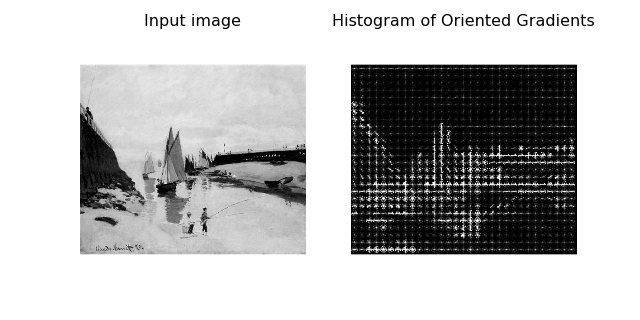

In [104]:
#for file in files:
f = files[1000]
print(f)
image = skimage.io.imread(f)
image = color.rgb2gray(image)

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualise=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')
ax1.set_adjustable('box-forced')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
ax1.set_adjustable('box-forced')
plt.show()

In [2]:
def normalize_images(files):
    minh = 1000000
    minw = 1000000
    for im,name in files:
        if im.shape[0] < minh:
            minh = im.shape[0]
        if im.shape[1] < minw:
            minw = im.shape[1]
    normalized = []
    for im,name in tqdm(files):
        cropped = im[im.shape[0]//2-minh//2:im.shape[0]//2+minh//2,im.shape[1]//2-minw//2:im.shape[1]//2+minw//2]
        normalized.append(cropped)
        if PATH['ABSTRACT'] in name:
            skimage.io.imsave(join(PATH['ABSTRACT_CROP'],basename(name)),cropped)
        elif PATH['IMPR'] in name:
            skimage.io.imsave(join(PATH['IMPR_CROP'],basename(name)),cropped)
    return normalized

In [9]:
def normalize_to_several_images(files):
    minh = 1000000
    minw = 1000000
    for im,name in files:
        if im.shape[0] < minh:
            minh = im.shape[0]
        if im.shape[1] < minw:
            minw = im.shape[1]
    normalized = []
    for im,name in tqdm(files):
        v_nimages = im.shape[0]//minh
        h_nimages = im.shape[1]//minw
        for iv in range(v_nimages):
            for ih in range(h_nimages):
                cropped = im[iv*minh:(iv+1)*minh, ih*minw:(ih+1)*minw]
                normalized.append(cropped)
                if PATH['ABSTRACT'] in name:
                    skimage.io.imsave(join(PATH['ABSTRACT_CROP'], str(iv) + "_" + str(ih) + "_" + basename(name)),cropped)
                elif PATH['IMPR'] in name:
                    skimage.io.imsave(join(PATH['IMPR_CROP'], str(iv) + "_" + str(ih) + "_" + basename(name)),cropped)
    return normalized

In [45]:
artists = os.listdir(PATH["ABSTRACT"])
artists.pop()
files = list()
for artist in artists:
    images = os.listdir(join(PATH["ABSTRACT"],artist))
    for image in images:
        files.append(PATH["ABSTRACT"] + artist + "\\" + image)
artists = os.listdir(PATH["IMPR"])
artists.pop()
for artist in artists:
    images = os.listdir(join(PATH["IMPR"],artist))
    for image in images:
        files.append(PATH["IMPR"] + artist + "\\" + image)

FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: '.\\Pandora_18k\\16_AbstractArt\\Abstract_Art\\'

In [11]:
openned_files = list()
for f in tqdm(files):
    if f != "":
        image = skimage.io.imread(f)
        openned_files.append((image,f))

print(openned_files[10][0].shape)

openned_files = normalize_to_several_images(openned_files)
print(openned_files[10][0].shape)

100%|█████████████████████████████████████████████████████████████████████████████| 1554/1554 [00:07<00:00, 221.56it/s]


(451, 355, 3)


100%|██████████████████████████████████████████████████████████████████████████████| 1554/1554 [00:55<00:00, 27.95it/s]


(185, 3)


In [13]:
X = list()
Y = list()
abstract_cropped = glob(join(PATH['ABSTRACT_CROP'],'*.jpg'))
for name in tqdm(abstract_cropped):
    Y.append(0)
    image = skimage.io.imread(name)
#     image = color.rgb2gray(image)
#     fd = hog(image, orientations=8, pixels_per_cell=(32, 32),
#                     cells_per_block=(1, 1))
    image = color.rgb2hsv(image)
    fd = exposure.histogram(image[:,:,0])[0]
#     fd = np.concatenate((exposure.histogram(image[:,:,0])[0],exposure.histogram(image[:,:,1])[0],exposure.histogram(image[:,:,2])[0]))
    X.append(fd)
impr_cropped = glob(join(PATH['IMPR_CROP'],'*.jpg'))
for name in tqdm(impr_cropped):
    Y.append(1)
    image = skimage.io.imread(name)
    image = color.rgb2hsv(image)
#     image = color.rgb2gray(image)
#     fd = hog(image, orientations=8, pixels_per_cell=(32, 32),
#                     cells_per_block=(1, 1))
#     fd = np.concatenate((exposure.histogram(image[:,:,0])[0],exposure.histogram(image[:,:,1])[0],exposure.histogram(image[:,:,2])[0]))
    fd = exposure.histogram(image[:,:,0])[0]
    X.append(fd)
X = np.asarray(X)
Y = np.asarray(Y)

100%|██████████████████████████████████████████████████████████████████████████████| 4815/4815 [00:52<00:00, 91.85it/s]


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 200)

In [15]:
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)
preds = classifier.predict(X_test)
print(f1_score(Y_test,preds))
print(f1_score(Y_test,np.ones(Y_test.shape)))

0.920353982301
0.895027624309


In [16]:
classifier = RandomForestClassifier()
cross_val_score(classifier,X,Y)

array([ 0.90192926,  0.9056806 ,  0.92386059])

In [18]:
782.0/4815

0.16240913811007268